In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import json

### MNIST dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) # Transform images into tensors

# Full MNIST training set (60,000 samples)
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split: 50,000 for training, 10,000 for validation
train_size = 50000
val_size = 10000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Test set (10,000 samples)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)



### Simple Neural Network Class

In [4]:
class SimpleNN(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=100, output_dim=10):
        super().__init__() #Calling the constructor of nn.Module
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x) # Apparently cross-entropy loss handles the softmax
        return x

### Evaluation in order to find the best lambda

In [6]:
def evaluation(lambda_reg, lr, epochs=800):
    model = SimpleNN()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=lambda_reg) #L2 applied here
    criterion = nn.CrossEntropyLoss()

    val_accuracies = []
    val_errors = []

    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            output = model(data)
            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        # Validation at the end of the epoch
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                pred = output.argmax(dim=1)
                correct += (pred == target).sum().item()
                total += target.size(0)

        val_acc = correct / total
        val_err = 1 - val_acc
        val_accuracies.append(val_acc)
        val_errors.append(val_err)

        if (epoch+1)%10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Val Acc: {val_acc:.4f} | Val Error: {val_err:.4f}")

    return val_accuracies, val_errors, model
    

In [ ]:
lr_candidates = [1, 1e-1, 0.1, 0.05]
lambda_candidates = [1e-5, 1e-4, 1e-3, 1e-2]
best_lambda = None
best_lr = None
best_val_acc = 0
best_val_error = 0
best_model = None
all_results = {}

for lr in lr_candidates:
    for lam in lambda_candidates:
        
        print(f"\n--- Training with λ = {lam:.0e}, lr = {lr:.0e} ---")

        val_accs, val_errors, model = evaluation(lam, lr, epochs=800)
        final_val_acc = val_accs[-1]
        final_val_error = val_errors[-1]

        all_results[(lam, lr)] = (val_accs, val_errors)

        if final_val_acc > best_val_acc:
            best_val_acc = final_val_acc
            best_val_error = final_val_error
            best_lambda = lam
            best_lr = lr
            best_model = model

print(f"Best learning rate: {best_lr}")
print(f"Best lambda: {best_lambda}")


#with open('/kaggle/working/all_val_results.json', 'w') as f:
#    json.dump({str(k): v[0] for k, v in all_results.items()}, f)


--- Training with λ = 1e-05, lr = 1e+00 ---
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\bruker\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\bruker\AppData\Local\Temp\ipykernel_37332\1454818759.py", line 15, in <module>
    val_accs, val_errors, model = evaluation(lam, lr, epochs=800)
  File "C:\Users\bruker\AppData\Local\Temp\ipykernel_37332\2367752889.py", line 11, in evaluation
    for data, target in train_loader:
  File "C:\Users\bruker\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\dataloader.py", line 708, in __next__
    data = self._next_data()
  File "C:\Users\bruker\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\utils\data\dataloader.py", 

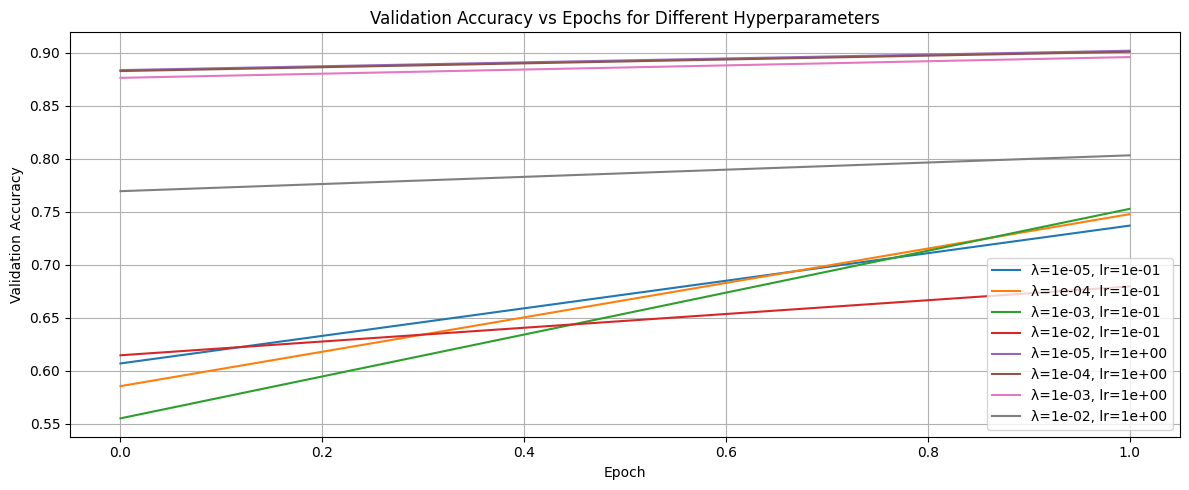

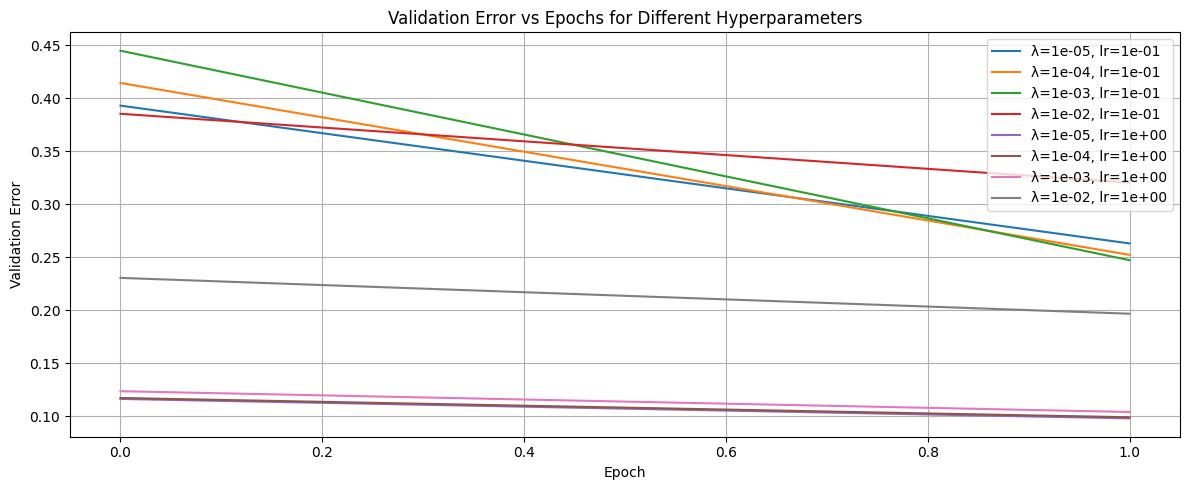

In [ ]:
plt.figure(figsize=(12, 5))

# Plot all validation accuracy curves
for (lam, lr), (val_accs, val_errors) in all_results.items():
    plt.plot(val_accs, label=f"λ={lam:.0e}, lr={lr:.0e}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Epochs for Different Hyperparameters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))
for (lam, lr), (val_accs, val_errors) in all_results.items():
    plt.plot(val_errors, label=f"λ={lam:.0e}, lr={lr:.0e}")

plt.xlabel("Epoch")
plt.ylabel("Validation Error")
plt.title("Validation Error vs Epochs for Different Hyperparameters")
plt.legend(loc = 'upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


### Training after finding best lambda

In [ ]:
# Final training using best lambda, log test error after each epoch
final_model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(final_model.parameters(), lr=best_lr, weight_decay=best_lambda) #, momentum=0.9) #L2
epochs = 800
test_errors = []

for epoch in range(1, epochs + 1):

    final_model.train()

    for data, target in train_loader:
        output = final_model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate test error after each epoch
    final_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = final_model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    test_error = 1 - (correct / total)
    test_errors.append(test_error)

    if (epoch+1)%10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Test Error: {test_error:.4f}")




Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\bruker\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\bruker\AppData\Local\Temp\ipykernel_37332\673037610.py", line 4, in <module>
    optimizer = torch.optim.SGD(final_model.parameters(), lr=best_lr, weight_decay=best_lambda) #L2
  File "C:\Users\bruker\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\optim\sgd.py", line 43, in __init__
    if lr < 0.0:
TypeError: '<' not supported between instances of 'NoneType' and 'float'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\bruker\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python3

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(50, epochs + 1), test_errors[49:], label='Test Error')  # Start from epoch 50
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.title('Test Error Over Epochs (Epoch 50 onward)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
